# Start


In [1]:
# !pip install tensorflow

In [2]:
import os
import shutil

import cv2
import kagglehub
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    InputLayer,
    MaxPooling2D,
    Rescaling,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image

In [3]:
df_train = pd.read_csv("../data/raw/faces/train.csv")

# Testing


## Definitions


In [4]:
BATCH_SIZE = 64
EPOCHS = 50


def get_dataset(size, color_mode):
    # Load dataset
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        f"../data/processed/faces/{color_mode}/{size}x{size}",
        shuffle=True,
        image_size=(size, size),
        batch_size=BATCH_SIZE,
    )

    # Split dataset
    data_size = len(ds)
    train_split = 0.7
    val_split = 0.2
    test_split = 0.1

    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    # Cache, shuffle and prefetch
    buffer_size = len(train_ds) * BATCH_SIZE
    buffer_size

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds


def get_input_shape(train_ds):
    for batch, _ in train_ds.take(1):
        return batch.shape

In [5]:
def show_accuracy(history):
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


def show_loss(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


def show_evaluation(model, val_ds, history):
    loss, acc = model.evaluate(val_ds, batch_size=BATCH_SIZE)
    print(f"Loss: {round(loss, 3)}, Acc: {round(acc*100, 3)}%")
    show_accuracy(history)
    show_loss(history)

In [6]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

## Main Model


In [ ]:
train_ds, val_ds, test_ds = get_dataset(64, "rgb")
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
input_shape = get_input_shape(train_ds)
input_shape

Found 18652 files belonging to 3 classes.


TensorShape([64, 64, 64, 3])

In [ ]:
model = Sequential(
    [
        # Preprocessing layers
        InputLayer(shape=input_shape[1:]),
        Rescaling(1.0 / 255),
        # Input and first conv block
        Conv2D(32, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        # Second conv block
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        # Third conv block
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        # Flatten and dense layers
        Flatten(),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [36]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
)

Epoch 1/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 26s 120ms/step - accuracy: 0.5591 - loss: 0.9133 - val_accuracy: 0.6452 - val_loss: 0.7960
Epoch 2/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.6425 - loss: 0.8141 - val_accuracy: 0.6422 - val_loss: 0.8041
Epoch 3/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.6680 - loss: 0.7551 - val_accuracy: 0.6778 - val_loss: 0.7340
Epoch 4/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.6805 - loss: 0.7351 - val_accuracy: 0.6864 - val_loss: 0.7125
Epoch 5/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - accuracy: 0.6956 - loss: 0.7002 - val_accuracy: 0.7131 - val_loss: 0.6631
Epoch 6/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.7144 - loss: 0.6653 - val_accuracy: 0.7279 - val_loss: 0.6562
Epoch 7/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.7227 - loss: 0.6533 - val_accuracy: 0.7320 - val_loss: 0.6383
Epoch 8/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.7323 - loss: 0.6312 

 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7969 - loss: 0.4702

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8117 - loss: 0.4786
Loss: 0.491, Acc: 80.738%


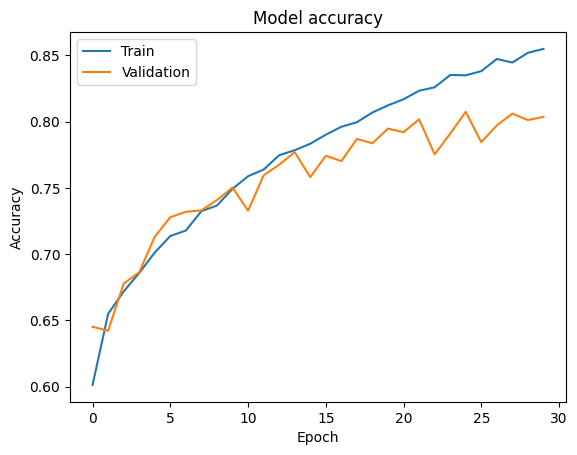

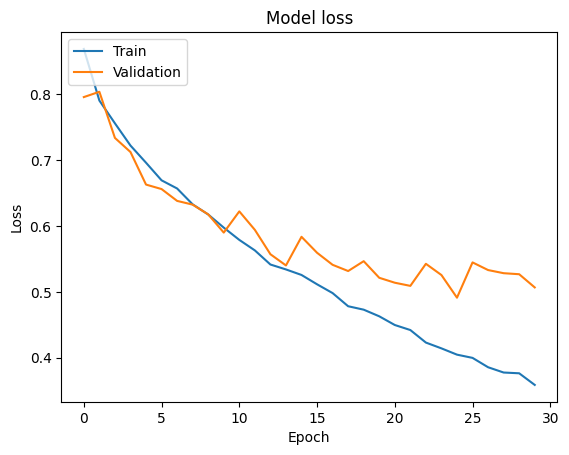

In [37]:
show_evaluation(model, val_ds, history)

## Models


### Model 1


In [10]:
train_ds, val_ds, test_ds = get_dataset(64, "rgb")
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
input_shape = get_input_shape(train_ds)
input_shape

NameError: name 'tf' is not defined

In [39]:
model = Sequential(
    [
        # Preprocessing layers
        InputLayer(shape=input_shape[1:]),
        Rescaling(1.0 / 255),
        # Input and first conv block
        Conv2D(16, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        # Second conv block
        Conv2D(32, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        # Third conv block
        Conv2D(192, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        # Flatten and dense layers
        Flatten(),
        Dense(128, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [40]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
)

Epoch 1/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.5623 - loss: 0.9174 - val_accuracy: 0.6549 - val_loss: 0.7854
Epoch 2/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.6466 - loss: 0.8012 - val_accuracy: 0.6608 - val_loss: 0.7681
Epoch 3/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.6662 - loss: 0.7600 - val_accuracy: 0.6923 - val_loss: 0.7150
Epoch 4/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.6803 - loss: 0.7326 - val_accuracy: 0.7082 - val_loss: 0.6931
Epoch 5/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.6978 - loss: 0.6982 - val_accuracy: 0.7284 - val_loss: 0.6537
Epoch 6/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.7144 - loss: 0.6620 - val_accuracy: 0.7201 - val_loss: 0.6711
Epoch 7/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.7150 - loss: 0.6637 - val_accuracy: 0.7333 - val_loss: 0.6384
Epoch 8/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.7254 - loss: 0.6390 - 

 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8594 - loss: 0.3091

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8202 - loss: 0.4813
Loss: 0.499, Acc: 80.954%


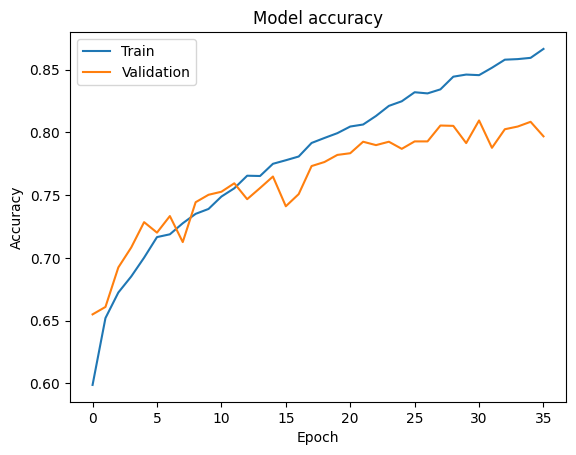

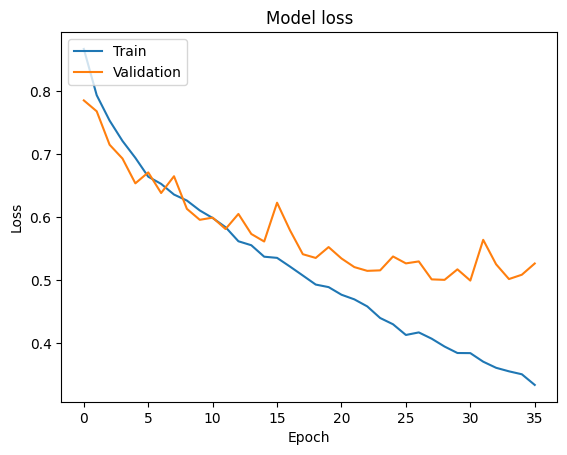

In [41]:
show_evaluation(model, val_ds, history)

### Model 2


In [ ]:
train_ds, val_ds, test_ds = get_dataset(64, "rgb")
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
input_shape = get_input_shape(train_ds)

Found 18652 files belonging to 3 classes.


In [ ]:
model = Sequential(
    [
        # Preprocessing layers
        InputLayer(shape=input_shape[1:]),
        Rescaling(1.0 / 255),
        # Input and first conv block
        Conv2D(32, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        # Second conv block
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        # Third conv block
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        # Flatten and dense layers
        Flatten(),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(3, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [44]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
)

Epoch 1/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.4894 - loss: 1.3880 - val_accuracy: 0.5563 - val_loss: 0.9821
Epoch 2/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.6091 - loss: 0.9150 - val_accuracy: 0.5132 - val_loss: 0.9475
Epoch 3/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 30s 148ms/step - accuracy: 0.6485 - loss: 0.8084 - val_accuracy: 0.5846 - val_loss: 0.9051
Epoch 4/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 143ms/step - accuracy: 0.6704 - loss: 0.7598 - val_accuracy: 0.6096 - val_loss: 0.8793
Epoch 5/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - accuracy: 0.6807 - loss: 0.7372 - val_accuracy: 0.6808 - val_loss: 0.7672
Epoch 6/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 31s 151ms/step - accuracy: 0.6924 - loss: 0.7225 - val_accuracy: 0.7147 - val_loss: 0.6921
Epoch 7/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.6986 - loss: 0.6969 - val_accuracy: 0.7144 - val_loss: 0.6736
Epoch 8/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.7024 - loss: 0

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8101 - loss: 0.4558
Loss: 0.475, Acc: 80.63%


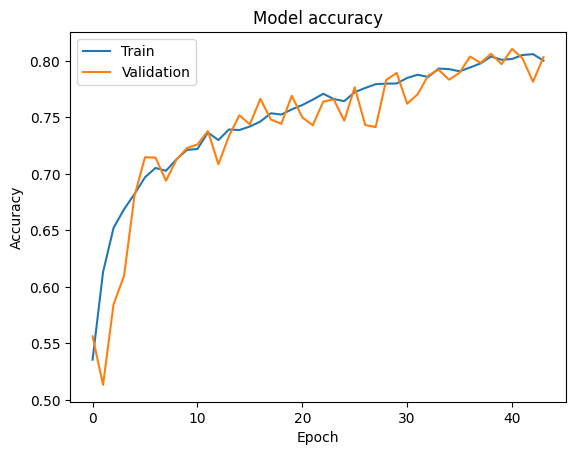

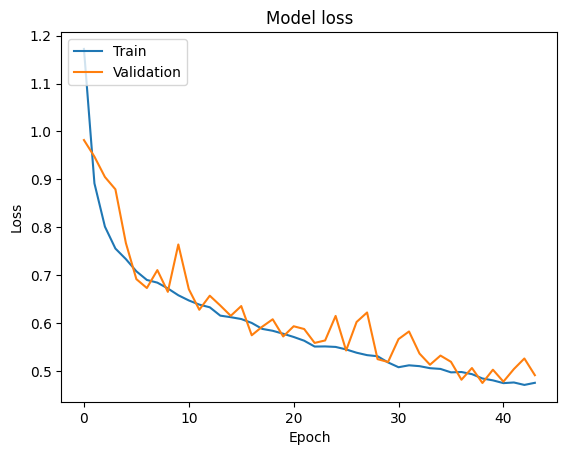

In [45]:
show_evaluation(model, val_ds, history)